In [57]:
%reset

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
print('Libraries imported - ready to use PyTorch', torch.__version__)

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

Libraries imported - ready to use PyTorch 1.13.1


In [50]:
%run prepare_augment_data.ipynb

Data loaders ready to read ../Datasets/asl_alphabet_train/


In [59]:
def load_dataset(data_path):
    import torch
    import torchvision
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader
    from torch.utils.data import random_split

    # define transformation to randomly augment image data
    transformation = transforms.Compose([
        # random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
        # random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # normalise pixel values (RGB channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # load all images and transform them
    full_dataset = ImageFolder(
        root=data_path,
        transform=transformation
    )

    # split dataset into 70% training and 30% test
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # random training/test split
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # define loader for training data
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    # define loader for testing data
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )
    
    return train_loader, test_loader

In [60]:
train_folder = '../Datasets/asl_alphabet_train/'

train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print('Data loaders ready to read', train_folder)

Data loaders ready to read ../Datasets/asl_alphabet_train/


base model for image classification

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                      # generate predications
        loss = F.cross_entropy(out, labels)     # calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                      # generate predictions
        loss = F.cross_entropy(out, labels)     # calculate loss
        acc = accuracy(out, labels)             # calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()          # combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']
        ))

architecture of CNN model

In [62]:
class Net(ImageClassificationBase):

    def __init__(self):
        """Defining the Constructor - define each layer to be used in our model"""
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
        # # RGB images, so we have 3 input channels
        # super(Net, self).__init__()

        # # apply 12 filters in first conv. layer
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # # second conv. layer takes 12 input channels and generates 24 outputs
        # self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        # # apply max pooling with kernel size 2
        # self.pool = nn.MaxPool2d(kernel_size=2)
        # # drop layer to delete 20% of features to help prevent overfitting
        # self.drop = nn.Dropout2d(p=0.2)

        # # 200x200 image tensors pooled twice with kernel size 2 -> feature tensors now 50x50, and 24 of them generated

        # # flatten feature tensors to feed to fully-connected layer
        # self.fc = nn.Linear(in_features=50*50*24, out_features=num_classes)

    def forward(self, x):
        """Pass data through layers defined in constructor"""
        return self.network(x)
        # #  use ReLU activation function after layer 1 (convolution 1 & pool)
        # x = F.relu(self.pool(self.conv1(x)))
        # # use ReLU activation function after layer 2
        # x = F.relu(self.pool(self.conv2(x)))
        # # select some features to drop to prevent overfitting
        # x = F.dropout(self.drop(x), training=self.training)
        # # flatten
        # x = x.view(-1, 50*50*24)
        # # feed to fully-connected layer to predict class
        # x = self.fc(x)

        # return torch.log_softmax(x, dim=1) # return class probabilities

hyperparameters, model training, and evaluation

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


train model

In [64]:
model = Net()
model

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, 

In [65]:
# helper function to load data into GPU

def get_default_device():
    """Set device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move data to the device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [66]:
device = get_default_device()
device

device(type='cpu')

In [67]:
# load data into GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(test_loader, device)
to_device(model, device)

# load model to the device
model = to_device(Net(), device)

In [68]:
# initial evaluation of model
evaluate(model, test_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x160000 and 82944x1024)

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs,lr,model,train_loader,test_loader,opt_func)

In [39]:
# def train(model, device, train_loader, optimizer, epoch):
#     # set model to training mode
#     model.train()
#     train_loss = 0
#     print("Epoch: ", epoch)

#     # process images in batches
#     for batch_idx, (data,target) in enumerate(train_loader):
#         # use CPU or GPU as appropriate - but GPU is optimized for our operations
#         data, target = data.to(device), target.to(device)

#         # reset the optimizer
#         optimizer.zero_grad()

#         # push data forward through model layers
#         output = model(data)

#         # get loss
#         loss = loss_criteria(output, target)

#         # keep a running total
#         train_loss += loss.item()

#         # backpropagate
#         loss.backward()
#         optimizer.step()

#         # print metrics to see progress
#         print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
    
#     # return average loss for the epoch
#     avg_loss = train_loss / (batch_idx + 1)
#     print('Training set: Average loss: {:.6f}'.format(avg_loss))
#     return avg_loss

In [40]:
# def test(model, device, test_loader):
#     # switch to evaluation mode (so we don't backpropagate or drop)
#     model.eval()
#     test_loss = 0
#     correct = 0

#     with torch.no_grad():
#         batch_count = 0
#         for data, target in test_loader:
#             batch_count += 1
#             data, target = data.to(device), target.to(device)

#             # get predicted classes for this batch
#             output = model(data)

#             # calculate loss for this batch
#             test_loss += loss_criteria(output, target).item()

#             # calculate accuracy for this batch
#             _, predicted = torch.max(output.data, 1)
#             correct += torch.sum(target == predicted).item()
    
#     # calculate average loss and total accuracy for this epoch
#     avg_loss = test_loss / batch_count
#     print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         avg_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)
#     ))
#     return avg_loss

In [41]:
# # use 'Adam' optimizer to adjust weights
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # specify loss criteria
# loss_criteria = nn.CrossEntropyLoss()

# # track metrics in arrays
# epoch_nums = []
# training_loss = []
# validation_loss = []

# # train over 10 epochs
# epochs = 3
# print('Training on', device)
# for epoch in range(1, epochs + 1):
#     train_loss = train(model, device, train_loader, optimizer, epoch)
#     test_loss = test(model, device, test_loader)
#     epoch_nums.append(epoch)
#     training_loss.append(train_loss)
#     validation_loss.append(test_loss)

Training on cpu
Epoch:  1
	Training batch 1 Loss: 3.356421
	Training batch 2 Loss: 34.516510
	Training batch 3 Loss: 15.443350
	Training batch 4 Loss: 4.228014
	Training batch 5 Loss: 3.354880
	Training batch 6 Loss: 3.337567
	Training batch 7 Loss: 3.334898
	Training batch 8 Loss: 3.330907
	Training batch 9 Loss: 3.332478
	Training batch 10 Loss: 3.337686
	Training batch 11 Loss: 3.331772
	Training batch 12 Loss: 3.333709
	Training batch 13 Loss: 3.327481
	Training batch 14 Loss: 3.335116
	Training batch 15 Loss: 3.331629
	Training batch 16 Loss: 3.333228
	Training batch 17 Loss: 3.334115
	Training batch 18 Loss: 3.332591
	Training batch 19 Loss: 3.334254
	Training batch 20 Loss: 3.334701
	Training batch 21 Loss: 3.335555
	Training batch 22 Loss: 3.331683
	Training batch 23 Loss: 3.340427
	Training batch 24 Loss: 3.331813
	Training batch 25 Loss: 3.324115
	Training batch 26 Loss: 3.329528
	Training batch 27 Loss: 3.344965
	Training batch 28 Loss: 3.322431
	Training batch 29 Loss: 3.33

graphs for model accuracy and losses

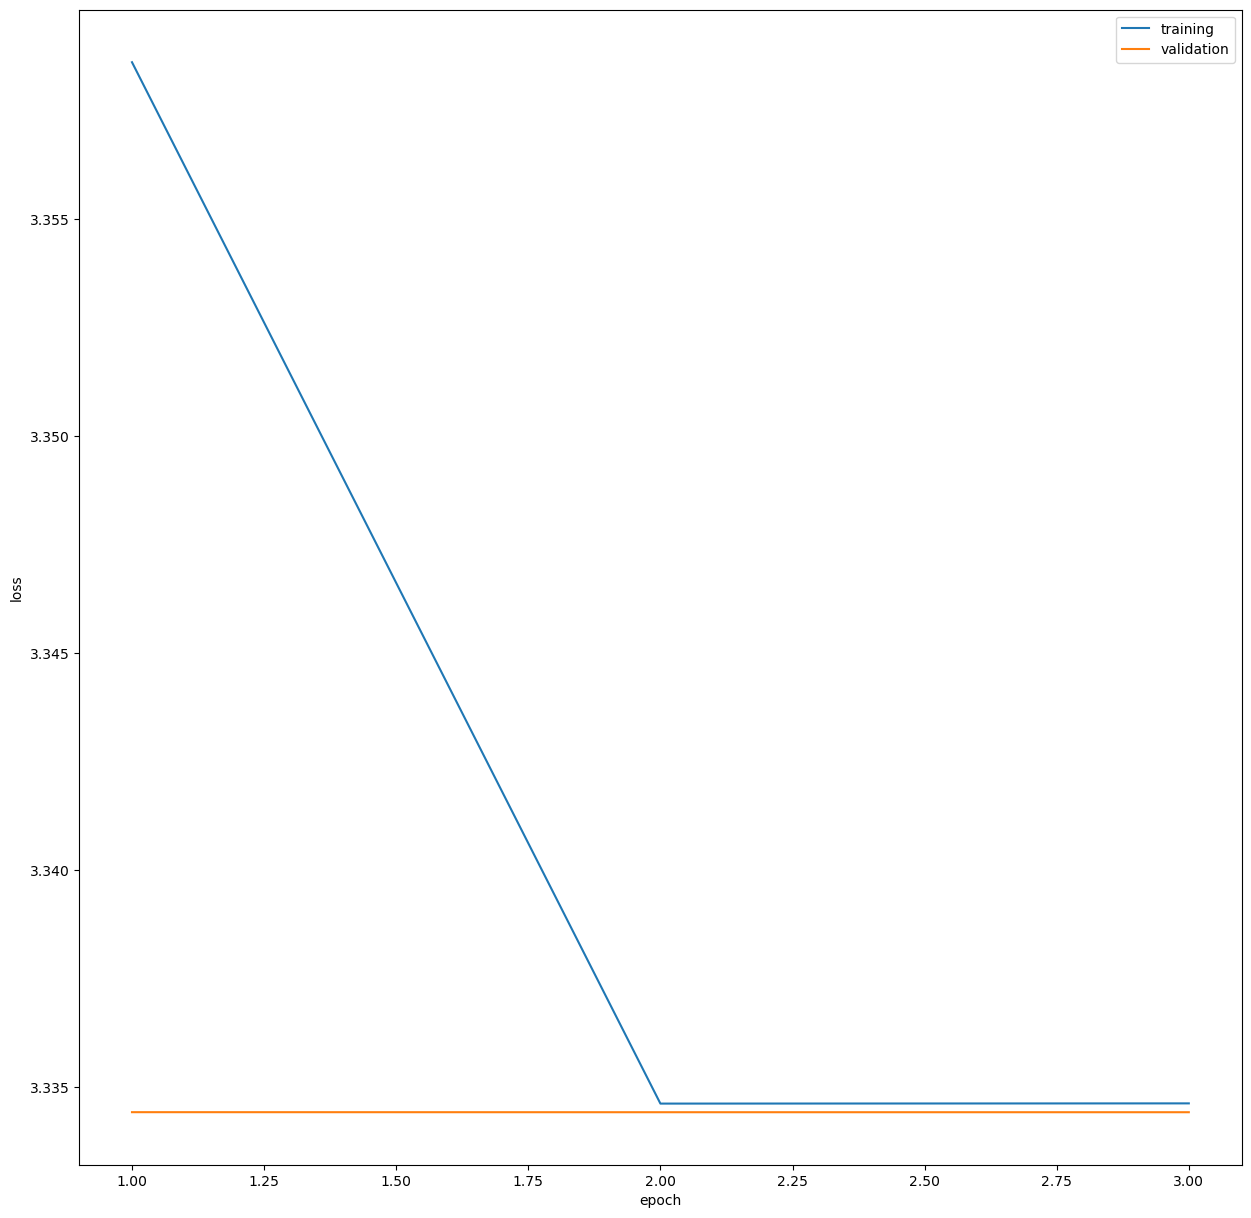

In [44]:
def plot_accuracies(history):
    """Plot history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """Plot losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

evaluate test data

In [ ]:
# apply model on test dataset and get results
test_loader = DeviceDataLoader(test_loader,device)
result = evaluate(model, test_loader)
result